# Espherical Graph Variational Autoencoder sobre Santiago

**Tarea**: reconstrucción de adyacencia del grafo.
**Loss**: Entropía cruzada binaria con regularización esférica

In [1]:
# Hyperspherical Graph VAE para grafo_santiago_filtrado_con_embeddings.gexf

import os
import math
import random
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import umap

import networkx as nx
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
from sklearn.metrics import roc_auc_score, average_precision_score

try:
    from torch_geometric.utils import from_networkx, negative_sampling, train_test_split_edges, to_undirected
    from torch_geometric.data import Data
    from torch_geometric.nn import GCNConv
except ImportError as e:
    raise ImportError(
        "Este notebook requiere torch_geometric. "
        "Instala con: pip install torch-geometric (y dependencias según tu sistema)."
    ) from e

from SGVAE import HypersphericalGraphVAE, CONFIGS

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device:", device)

/Users/diegolarraguibel/Desktop/Semestre 2025-2/Aprendizaje en Grafos/github_aprendizaje_grafos/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: mps


In [3]:
GRAPH_PATH = "../../data/grafo_santiago_filtrado_con_embeddings.gexf"
G_nx = nx.read_gexf(GRAPH_PATH)

print(f"Nodos: {G_nx.number_of_nodes()}, Aristas: {G_nx.number_of_edges()}")

# 2. Inspeccionar atributos para detectar columnas de embeddings
sample_node = next(iter(G_nx.nodes(data=True)))[1]
print("Atributos de ejemplo de un nodo:\n", sample_node)

# Detectar columnas de embeddings: todas las claves que parezcan A00, A01, ...
emb_keys = sorted([k for k in sample_node.keys() if k.startswith("A")])
if not emb_keys:
    raise ValueError("No se encontraron columnas de embeddings tipo 'e_0, e_1, ...' en los nodos.")

emb_dim = len(emb_keys)
print(f"Detectadas {emb_dim} dimensiones de embedding AE.")

# Detectar tipos de OSM
tipos = set()
for _, data in G_nx.nodes(data=True):
    t = data.get("tipo", None)
    if t is not None:
        tipos.add(str(t))
tipos = sorted(list(tipos))
tipo2idx = {t: i for i, t in enumerate(tipos)}

print(f"Se encontraron {len(tipos)} tipos de POI OSM.")

# 3. Construir matriz de features nodales
num_nodes = G_nx.number_of_nodes()
tipo_dim = len(tipos)

X = np.zeros((num_nodes, tipo_dim + emb_dim), dtype=np.float32)

# Mapear node ids de NetworkX a índice entero 0..N-1
node_id_to_idx = {node_id: i for i, node_id in enumerate(G_nx.nodes())}

missing_tipo = 0
missing_emb = 0

for node_id, data in G_nx.nodes(data=True):
    i = node_id_to_idx[node_id]
    
    # One-hot de tipo
    t = data.get("tipo", None)
    if t is not None and str(t) in tipo2idx:
        tipo_idx = tipo2idx[str(t)]
        X[i, tipo_idx] = 1.0
    else:
        missing_tipo += 1
    
    # Embeddings AE
    emb_vals = []
    for k in emb_keys:
        val = data.get(k, None)
        if val is None:
            emb_vals = None
            break
        try:
            emb_vals.append(float(val))
        except ValueError:
            emb_vals = None
            break
    
    if emb_vals is not None:
        X[i, tipo_dim:] = np.array(emb_vals, dtype=np.float32)
    else:
        missing_emb += 1

print(f"Nodos sin tipo asignado: {missing_tipo}")
print(f"Nodos sin embedding completo: {missing_emb}")

# 4. Crear objeto PyG Data
# Usamos from_networkx y luego reemplazamos x con nuestra matriz
G_tmp = nx.relabel_nodes(G_nx, node_id_to_idx)  # asegurar nodos 0..N-1
data = from_networkx(G_tmp)

# Asegurar que edge_index está bien formateado
edge_index = data.edge_index

# Asignar features
data.x = torch.from_numpy(X)
data.num_nodes = num_nodes
data = data.to(device)
print(data)


Nodos: 29267, Aristas: 303540
Atributos de ejemplo de un nodo:
 {'lat': -33.4395505, 'lon': -70.6511137, 'tipo': 'comercio', 'nombre': 'Lentes Online', 'A00': 0.07759969242599, 'A01': -0.1409747020376778, 'A02': 0.17469219530949634, 'A03': -0.08710003844675125, 'A04': -0.04537331795463283, 'A05': -0.2385051903114187, 'A06': 0.0858722029988466, 'A07': 0.06849796232218378, 'A08': -0.20947512495194157, 'A09': 0.07512187620146098, 'A10': 0.05920430603613995, 'A11': 0.10161507112648982, 'A12': 0.07087489427143406, 'A13': 0.0667435601691657, 'A14': -0.11246874279123414, 'A15': -0.045562783544790465, 'A16': 0.20536347558631296, 'A17': 0.03699746251441753, 'A18': 0.1430957324106113, 'A19': 0.11327581699346405, 'A20': -0.03000938100730488, 'A21': 0.05978254517493272, 'A22': -0.0975920030757401, 'A23': 0.005878354479046518, 'A24': 0.06543452518262206, 'A25': 0.012175009611687812, 'A26': -0.1297371780084583, 'A27': 0.06900484429065744, 'A28': 0.037332103037293354, 'A29': -0.20038815840061516, 'A3

In [4]:
data.edge_index = to_undirected(data.edge_index)

data_split = train_test_split_edges(
    data,
    val_ratio=0.05,
    test_ratio=0.10
)



Edges usados: 607080


In [6]:
# 1. Tomar la mejor config según AUC (ya calculado en la grilla)
best_cfg = results_sorted[0]
print("Mejor configuración encontrada:")
print(best_cfg)

best_params = dict(
    latent_dim=best_cfg["latent_dim"],
    hidden_dim=best_cfg["hidden_dim"],
    noise_scale=best_cfg["noise_scale"],
    lambda_uniform=best_cfg["lambda_uniform"],
)

# 2. Re-entrenar SOLO el mejor modelo con más épocas (un poco más largo que en la grilla)
EPOCHS_BEST = 100
LR = 1e-3
WEIGHT_DECAY = 1e-5
NEG_PER_POS = None  # mismo número de negativos que positivos

model_best = HypersphericalGraphVAE(
    in_dim=data.x.size(1),
    hidden_dim=best_params["hidden_dim"],
    latent_dim=best_params["latent_dim"],
    noise_scale=best_params["noise_scale"],
    lambda_uniform=best_params["lambda_uniform"],
).to(device)

optimizer = torch.optim.Adam(
    model_best.parameters(),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

print("\nEntrenando mejor modelo con más épocas para visualización...")

for epoch in range(1, EPOCHS_BEST + 1):
    model_best.train()
    optimizer.zero_grad()

    pos_edge_index, neg_edge_index = get_pos_neg_edges(
        data.edge_index,
        data.num_nodes,
        num_neg=NEG_PER_POS
    )
    pos_edge_index = pos_edge_index.to(device)
    neg_edge_index = neg_edge_index.to(device)

    loss, recon_loss, reg_uniform, mu, z = model_best(
        data.x, data.edge_index, pos_edge_index, neg_edge_index
    )

    loss.backward()
    optimizer.step()

    if epoch % 20 == 0 or epoch == 1:
        print(
            f"Epoch {epoch:03d} | "
            f"Loss: {loss.item():.4f} | "
            f"Recon: {recon_loss.item():.4f} | "
            f"Reg: {reg_uniform.item():.6f}"
        )

print("Entrenamiento del mejor modelo completado.")


Mejor configuración encontrada:
{'name': 'G_lat64_h256_ns005_lu1e-3', 'latent_dim': 64, 'hidden_dim': 256, 'noise_scale': 0.05, 'lambda_uniform': 0.001, 'auc': 0.9980242637573954, 'ap': 0.998126123846443, 'mean_norm': 0.01673329994082451}

Entrenando mejor modelo con más épocas para visualización...
Epoch 001 | Loss: 0.7200 | Recon: 0.7194 | Reg: 0.671232
Epoch 020 | Loss: 0.5433 | Recon: 0.5433 | Reg: 0.015914
Epoch 040 | Loss: 0.5373 | Recon: 0.5373 | Reg: 0.002398
Epoch 060 | Loss: 0.5341 | Recon: 0.5341 | Reg: 0.000650
Epoch 080 | Loss: 0.5323 | Recon: 0.5323 | Reg: 0.000225
Epoch 100 | Loss: 0.5316 | Recon: 0.5316 | Reg: 0.000159
Entrenamiento del mejor modelo completado.


In [7]:
model_best.eval()
with torch.no_grad():
    mu_best, z_best = model_best.encode(data.x, data.edge_index)
    z_best = F.normalize(z_best, p=2, dim=-1)

z_np = z_best.cpu().numpy()
print("Embeddings nodales shape:", z_np.shape)

Embeddings nodales shape: (29267, 64)


In [8]:
# Normalizar por seguridad (ya están normalizados, pero no molesta)
norms = np.linalg.norm(z_np, axis=1, keepdims=True) + 1e-8
z_unit = z_np / norms

reducer = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    n_components=2,
    metric="cosine",
    random_state=42,
)
z_2d = reducer.fit_transform(z_unit)

print("UMAP listo. z_2d shape:", z_2d.shape)


/Users/diegolarraguibel/Desktop/Semestre 2025-2/Aprendizaje en Grafos/github_aprendizaje_grafos/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP listo. z_2d shape: (29267, 2)


/var/folders/w5/kmvyzkpj2q1fyf7tnn3nqwb40000gn/T/ipykernel_98123/648502883.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_tipos)


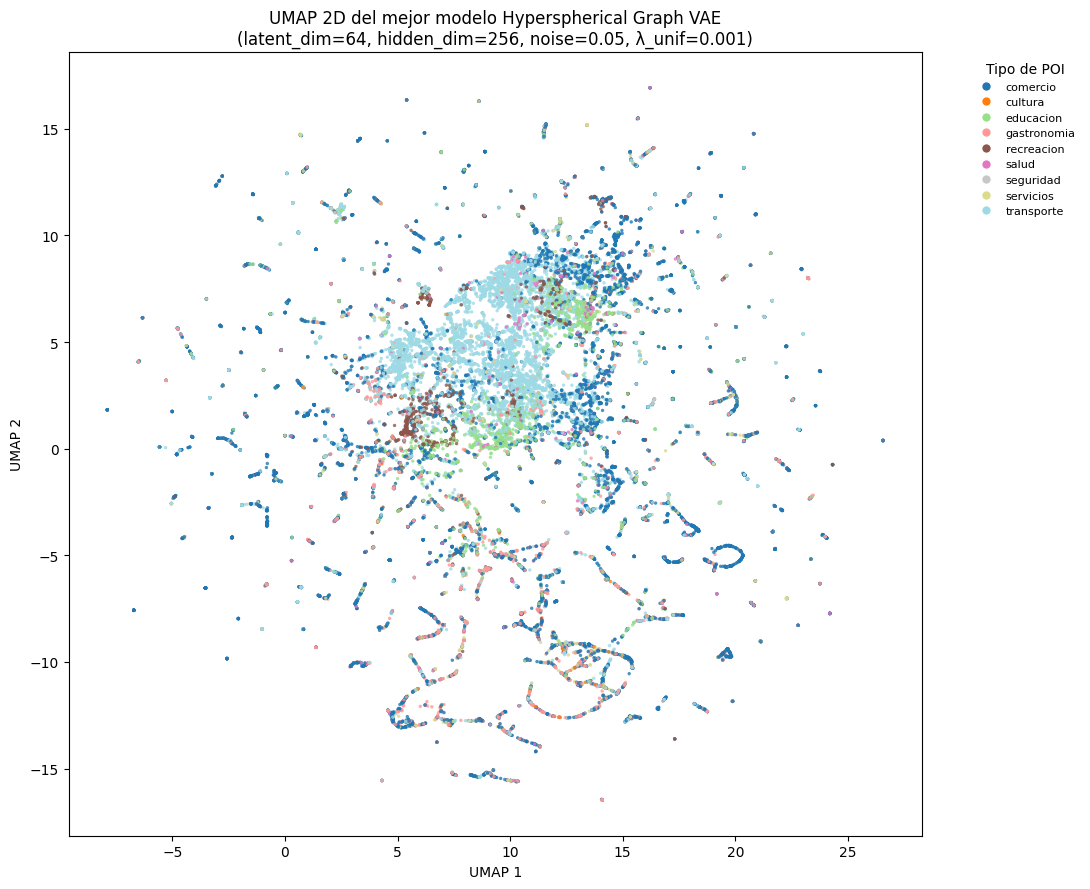

In [9]:
idx_to_node_id = {i: node_id for node_id, i in node_id_to_idx.items()}
tipos_por_nodo = []
for i in range(len(z_2d)):
    node_id = idx_to_node_id[i]
    t = G_nx.nodes[node_id].get("tipo", "desconocido")
    tipos_por_nodo.append(str(t))

tipos_unicos = sorted(set(tipos_por_nodo))
num_tipos = len(tipos_unicos)

# Colormap categórico
cmap = cm.get_cmap('tab20', num_tipos)
tipo_to_color = {t: cmap(i) for i, t in enumerate(tipos_unicos)}

colors = np.array([tipo_to_color[t] for t in tipos_por_nodo])

plt.figure(figsize=(11, 9))
plt.scatter(
    z_2d[:, 0],
    z_2d[:, 1],
    c=colors,
    s=6,
    alpha=0.8,
    linewidths=0
)

# Leyenda con colores correctos
handles = [
    plt.Line2D(
        [0], [0],
        marker='o',
        color='w',
        label=t,
        markerfacecolor=tipo_to_color[t],
        markersize=7
    )
    for t in tipos_unicos
]

plt.legend(
    handles=handles,
    title="Tipo de POI",
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    frameon=False,
    fontsize=8
)

plt.title(
    f"UMAP 2D del mejor modelo Hyperspherical Graph VAE\n"
    f"(latent_dim={best_params['latent_dim']}, "
    f"hidden_dim={best_params['hidden_dim']}, "
    f"noise={best_params['noise_scale']}, "
    f"λ_unif={best_params['lambda_uniform']})"
)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.tight_layout()
plt.show()
